# import libraries

In [ ]:
pip install tokenizers


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import pandas as pd
import random

In [ ]:
class MySelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(MySelfAttention, self).__init__()
        self.hidden_size = hidden_size

        # Define linear transformations for queries, keys, and values
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)

        # Define a scaling factor for the attention scores (sqrt(d))
        self.scale_factor = torch.sqrt(torch.FloatTensor([hidden_size]))

    def forward(self,x, mask):
        # Project the values, keys, and queries into their respective spaces
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)

        # Convert keys tensor to dense tensor
        K = K.to_dense()

        # Compute the dot products of query and key vectors QK^T
        energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale_factor # before softmax

        # Apply masking if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Apply softmax to obtain attention weights
        attention_weights = torch.nn.functional.softmax(energy, dim=-1)

        # Multiply attention weights by values
        output = torch.matmul(attention_weights, V)

        return output


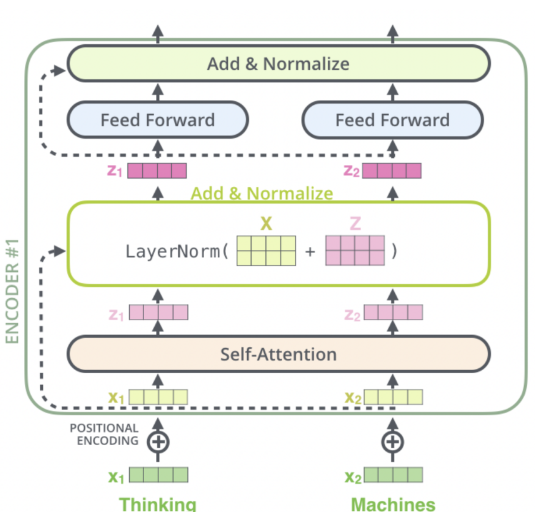

In [ ]:
class BaseEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(BaseEncoder, self).__init__()
        self.self_attention = MySelfAttention(hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Linear(hidden_size, hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, input_data, mask):
        # Apply self-attention mechanism
        attention_output = self.self_attention(input_data,mask)

        # Apply layer normalization and residual connection
        normalized_input = self.layer_norm1(attention_output + input_data)

        # Apply feed-forward layer
        feed_forward_output = self.feed_forward(normalized_input)

        # Apply layer normalization and residual connection again
        output = self.layer_norm2(feed_forward_output + normalized_input)

        return output


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_encoders):
        super(Encoder, self).__init__()
        self.embedding_size = hidden_size
        self.embedding_layer = nn.Embedding(vocab_size, self.embedding_size)
        self.encoder_layers = nn.ModuleList([BaseEncoder(self.embedding_size) for i in range(num_encoders)])
        self.fc_output = nn.Linear(self.embedding_size, vocab_size)

    def forward(self, input_data, mask):
        embedded_input = self.embedding_layer(input_data)
        for layer in self.encoder_layers:
            embedded_input = layer(embedded_input, mask)
        embedding_output = embedded_input
        final_output = self.fc_output(embedded_input)

        return torch.nn.functional.softmax(final_output, dim=-1), embedding_output # softmax over vocabulary , emb of that word


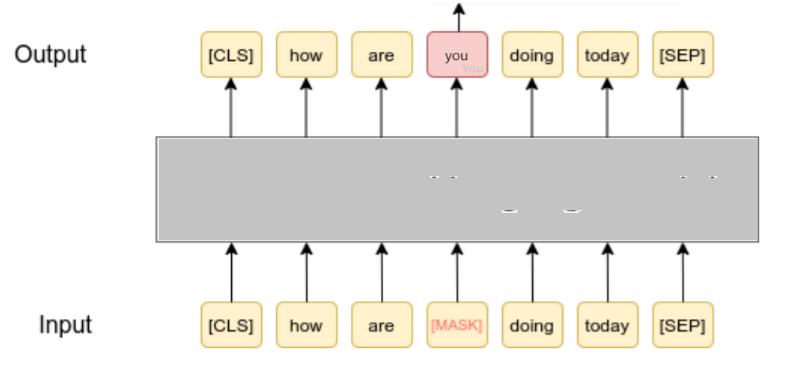

In [ ]:
def preprocess_sentences(sentences,max_length=128):
    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Initialize lists to store token IDs
    org_token_ids_list = []
    masked_token_ids_list = []

    # Iterate over each sentence
    for sentence in sentences:
        # Tokenize the sentence
        tokens = tokenizer.tokenize(sentence)
        tokens = tokens[:max_length - 2]  # Account for [CLS] and [SEP] tokens
        tokens = tokens + ['[PAD]'] * (max_length - len(tokens))
        mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

        # Get indices of 15% of words from the corpus
        sampled_indices = random.sample(range(len(tokens)), int(0.15 * len(tokens)))

        # Initialize lists to store masked tokens
        masked_tokens = []

        # Iterate over each token index
        for i in range(len(tokens)):
            # If the index is in the sampled indices
            if i in sampled_indices:
                # Mask 80% of the selected tokens
                if random.random() < 0.8:

                    masked_tokens.append(mask_token_id)
                # Replace 10% of the selected tokens with a random token
                elif random.random() < 0.1:
                    random_token = random.choice(list(tokenizer.vocab.keys()))
                    masked_tokens.append(tokenizer.convert_tokens_to_ids([random_token])[0])
                else:
                    masked_tokens.append(tokenizer.convert_tokens_to_ids([tokens[i]])[0])
            else:
                masked_tokens.append(tokenizer.convert_tokens_to_ids([tokens[i]])[0])

        # Convert tokens to token IDs
        org_token_ids = tokenizer.convert_tokens_to_ids(tokens)
        masked_token_ids = masked_tokens

        # Append token IDs to the lists
        org_token_ids_list.append(torch.tensor(org_token_ids))
        masked_token_ids_list.append(torch.tensor(masked_token_ids))

    return org_token_ids_list, masked_token_ids_list




In [ ]:
df = pd.read_csv("/content/mammoreport - mammoreport.csv")
df.head()
sentences = list(df['Features'].values)[:100]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
org_token_ids, masked_token_ids = preprocess_sentences(sentences)

# Print the original and masked token IDs for each sentence
for i in range(len(sentences)):
    print("Original token IDs:", org_token_ids[i])
    print("Masked token IDs:", masked_token_ids[i])
    print()
    break

Original token IDs: tensor([ 3730,  8153,  3742,  4649,  3258,  1006,  2603,  1060,  2322,  3461,
         1007,  2007, 11867, 24153,  2094, 17034,  3264,  1999,  1996,  4942,
        12069, 19478,  2555,  2012,  1017,  1521,  1051,  5119,  2597,  2007,
        10256, 14298,  2128,  6494,  7542,  1012,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

In [ ]:
input_tensors = torch.stack(masked_token_ids)
output_tensors = torch.stack(org_token_ids)
input_tensors.shape

torch.Size([100, 128])

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# Create dataset and dataloader
dataset = MyCustomDataset(input_tensors, output_tensors)
training_dataset = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
for batch in training_dataset:
    inputs, outputs = batch
    print("Input:", inputs.shape)
    print("Output:", outputs.shape)

In [ ]:
vocab_size = len(tokenizer)
embed_size = 128

In [ ]:
model = Encoder(vocab_size, embed_size,12) #12 encoders

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, outputs in training_dataset:
        optimizer.zero_grad()
        inputs = inputs.squeeze(0)  # Remove batch dimension
        outputs = outputs.squeeze(0)  # Remove batch dimension
        mask = (inputs != tokenizer.pad_token_id)
        predictions = model(inputs, mask)[0]
        loss = criterion(predictions.view(-1, vocab_size), outputs.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(training_dataset)}")

Epoch 1, Loss: 10.309209022521973
Epoch 2, Loss: 10.309084510803222
Epoch 3, Loss: 10.309084510803222
Epoch 4, Loss: 10.309084510803222
Epoch 5, Loss: 10.309084510803222
Epoch 6, Loss: 10.309084510803222
Epoch 7, Loss: 10.309084510803222
Epoch 8, Loss: 10.309084510803222
Epoch 9, Loss: 10.309084510803222
Epoch 10, Loss: 10.309084510803222


In [ ]:
# Tokenize the sentence
tokens = tokenizer.tokenize("cyst")

# Convert tokens to IDs
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert input_ids to tensor and add batch dimension
input_tensor = torch.tensor([input_ids])

word_embedding = model(input_tensor,None)[1]
a = word_embedding[0][0]

print(word_embedding[0][0])

print("\nDimension of embedding: ",word_embedding[0].shape)

tensor([ 0.6447,  2.1619,  0.0441, -0.8917,  1.5617,  1.7396, -1.4965,  0.1601,
         1.3394, -0.8729, -1.1240,  1.1233,  0.6895,  1.9101, -0.3343,  0.5005,
         1.0659, -1.2248, -1.4618,  1.4645,  1.2102, -1.3455,  1.0339,  1.3703,
        -1.5144,  1.5741, -1.4501,  1.5270,  0.3035,  0.0220,  0.6772, -2.2058,
        -0.5053,  1.7309, -1.4835, -1.6093, -0.1053,  0.2138,  0.0348,  1.0488,
        -0.5946,  1.4917,  1.4676,  1.4661, -1.6646, -1.3852, -1.9123, -0.5148,
         1.6615,  1.0886,  1.9864, -1.2935,  1.4425,  1.2033, -0.6782,  0.4888,
        -2.1017,  1.4623, -2.3228,  0.5206,  1.9648,  1.0097, -0.0692,  0.2421,
         1.6448,  0.0499, -1.2547, -1.5013,  1.5999, -0.9457, -0.9869, -1.2118,
        -1.1639, -0.0608,  1.1345,  1.4435,  1.1585,  1.4034, -1.4775,  2.3511,
        -1.4388, -0.9142,  2.1783,  0.8309, -1.7286, -2.3049, -1.3388,  1.3560,
         0.9437, -1.4382,  0.2822, -1.7063, -0.4665, -0.7345, -1.5676,  1.6964,
        -0.7777, -0.1480,  0.0304,  1.34

In [ ]:
# Tokenize the sentence
tokens = tokenizer.tokenize("glandular")

# Convert tokens to IDs
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert input_ids to tensor and add batch dimension
input_tensor = torch.tensor([input_ids])

word_embedding = model(input_tensor,None)[1]
b = word_embedding[0][0]

print(word_embedding[0][0])

print("\nDimension of embedding: ",word_embedding[0].shape)

tensor([ 0.6447,  2.1619,  0.0441, -0.8917,  1.5617,  1.7396, -1.4965,  0.1601,
         1.3394, -0.8729, -1.1240,  1.1233,  0.6895,  1.9101, -0.3343,  0.5005,
         1.0659, -1.2248, -1.4618,  1.4645,  1.2102, -1.3455,  1.0339,  1.3703,
        -1.5144,  1.5741, -1.4501,  1.5270,  0.3035,  0.0220,  0.6772, -2.2058,
        -0.5053,  1.7309, -1.4835, -1.6093, -0.1053,  0.2138,  0.0348,  1.0488,
        -0.5946,  1.4917,  1.4676,  1.4661, -1.6646, -1.3852, -1.9123, -0.5148,
         1.6615,  1.0886,  1.9864, -1.2935,  1.4425,  1.2033, -0.6782,  0.4888,
        -2.1017,  1.4623, -2.3228,  0.5206,  1.9648,  1.0097, -0.0692,  0.2421,
         1.6448,  0.0499, -1.2547, -1.5013,  1.5999, -0.9457, -0.9869, -1.2118,
        -1.1639, -0.0608,  1.1345,  1.4435,  1.1585,  1.4034, -1.4775,  2.3511,
        -1.4388, -0.9142,  2.1783,  0.8309, -1.7286, -2.3049, -1.3388,  1.3560,
         0.9437, -1.4382,  0.2822, -1.7063, -0.4665, -0.7345, -1.5676,  1.6964,
        -0.7777, -0.1480,  0.0304,  1.34

In [ ]:
# Tokenize the sentence
tokens = tokenizer.tokenize("Parenchyma")

# Convert tokens to IDs
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert input_ids to tensor and add batch dimension
input_tensor = torch.tensor([input_ids])

word_embedding = model(input_tensor,None)[1]
c = word_embedding[0][0]
print(word_embedding[0][0])

print("\nDimension of embedding: ",word_embedding[0].shape)

tensor([ 0.6447,  2.1619,  0.0441, -0.8917,  1.5617,  1.7396, -1.4965,  0.1601,
         1.3394, -0.8729, -1.1240,  1.1233,  0.6895,  1.9101, -0.3343,  0.5005,
         1.0659, -1.2248, -1.4618,  1.4645,  1.2102, -1.3455,  1.0339,  1.3703,
        -1.5144,  1.5741, -1.4501,  1.5270,  0.3035,  0.0220,  0.6772, -2.2058,
        -0.5053,  1.7309, -1.4835, -1.6093, -0.1053,  0.2138,  0.0348,  1.0488,
        -0.5946,  1.4917,  1.4676,  1.4661, -1.6646, -1.3852, -1.9123, -0.5148,
         1.6615,  1.0886,  1.9864, -1.2935,  1.4425,  1.2033, -0.6782,  0.4888,
        -2.1017,  1.4623, -2.3228,  0.5206,  1.9648,  1.0097, -0.0692,  0.2421,
         1.6448,  0.0499, -1.2547, -1.5013,  1.5999, -0.9457, -0.9869, -1.2118,
        -1.1639, -0.0608,  1.1345,  1.4435,  1.1585,  1.4034, -1.4775,  2.3511,
        -1.4388, -0.9142,  2.1783,  0.8309, -1.7286, -2.3049, -1.3388,  1.3560,
         0.9437, -1.4382,  0.2822, -1.7063, -0.4665, -0.7345, -1.5676,  1.6964,
        -0.7777, -0.1480,  0.0304,  1.34

In [ ]:
dot_product = torch.dot(a, b)

# Calculate magnitudes
magnitude_a = torch.norm(a)
magnitude_b = torch.norm(b)

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude_a * magnitude_b)
print("cosine sim : ",cosine_similarity)

cosine sim :  tensor(-0.9885, grad_fn=<DivBackward0>)


In [ ]:
dot_product = torch.dot(a, c)

# Calculate magnitudes
magnitude_a = torch.norm(a)
magnitude_b = torch.norm(b)

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude_a * magnitude_b)
print("cosine sim : ",cosine_similarity)

cosine sim :  tensor(1.0000, grad_fn=<DivBackward0>)
